# Averaged data

In [1]:
from pandas import HDFStore, DataFrame, Series, IndexSlice
from tqdm.auto import tqdm
from pandas import concat
from itertools import product

from sys import path
path.append("../")
from src.feature_extraction.eda import EDA_FEATURE_NAMES

eda_components = ['mixed-EDA', 'phasic-EDA', 'tonic-EDA']


def load_averaged_data(path: str) -> tuple[DataFrame, Series, Series]:
    loaded_data: dict[str, DataFrame] = {}

    # Open the HDF5 file
    with HDFStore(path) as store:
        # Iterate through the keys (group names) in the HDF5 file
        for key in tqdm(store.keys(), desc='Loading data'):
            # Load each DataFrame and store it in the dictionary
            loaded_data[key] = store[key]

    concated_df_avgs = concat(
        [loaded_data[key].loc[:, IndexSlice["Average", :]] for key in loaded_data.keys()],
        axis=1,
        keys=[el[1:] for el in loaded_data.keys()],
    )
    concated_df_errs = concat(
        [loaded_data[key].loc[:, IndexSlice["Standard error", :]] for key in loaded_data.keys()],
        axis=1,
        keys=[el[1:] for el in loaded_data.keys()],
    )
    df_avgs = concated_df_avgs.stack(level=[0,1]).reset_index(drop=False)
    df_avgs = df_avgs.drop(labels=['level_2'], axis=1, inplace=False)
    
    df_avgs.columns = ["classifier", "side", "Balanced Accuracy", *list(product(eda_components, EDA_FEATURE_NAMES))]

    df_errs = concated_df_errs.stack(level=[0,1]).reset_index(drop=False)
    df_errs = df_errs.drop(labels=['level_2'], axis=1, inplace=False)
    df_errs.columns = ["classifier", "side", "Balanced Accuracy", *list(product(eda_components, EDA_FEATURE_NAMES))]
    upper_errs = df_errs["Balanced Accuracy"]
    lower_errs = df_errs["Balanced Accuracy"]
    return df_avgs, upper_errs, lower_errs, df_errs
    
def make_linerrorplot(data: DataFrame, lower_errs: Series, upper_errs: Series, path_to_save: str) -> None:
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    
    plt.figure(figsize=(3, 7))
    sns.set_style("darkgrid")
    
    palette = sns.color_palette("colorblind")
    # sns.scatterplot(data=df, x='side', y='Balanced Accuracy', hue='classifier')
    plt.errorbar(
        x=data["side"],
        y=data["Balanced Accuracy"],
        xerr=None,
        yerr=(lower_errs, upper_errs),
        # label=custom_label,
        elinewidth=5,
        linestyle="none",
        markersize=1,
        marker=".",
        color=palette[0],
        ecolor=(*palette[0], 0.3),
    )
    plt.ylim(0.5, 1.0)
    
    plt.savefig(path_to_save, bbox_inches="tight")
    plt.show()
    # legend off
    # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    # 

## USILaughs - all max resources

In [2]:
path_to_save_data_avgs = "../data.nosync/usilaughs/results/nested_xgboost_featureselection_avg.h5"
# Create an empty dictionary to store the loaded DataFrames
df_avgs, upper_errs, lower_errs, df_errs = load_averaged_data(path_to_save_data_avgs)

Loading data:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
df_avgs

,classifier,side,Balanced Accuracy,"(mixed-EDA, min_feat)","(mixed-EDA, max_feat)","(mixed-EDA, mean_feat)","(mixed-EDA, std_feat)","(mixed-EDA, dynamic_range_feat)","(mixed-EDA, slope_feat)","(mixed-EDA, absolute_slope_feat)",...,"(tonic-EDA, slope_feat)","(tonic-EDA, absolute_slope_feat)","(tonic-EDA, first_derivetive_mean_feat)","(tonic-EDA, first_derivative_std_feat)","(tonic-EDA, number_of_peaks_feat)","(tonic-EDA, peaks_amplitude_feat)","(tonic-EDA, dc_term)","(tonic-EDA, sum_of_all_coefficients)","(tonic-EDA, information_entropy)","(tonic-EDA, spectral_energy)"
0,XGBClassifier,left,0.797187,0.038394,0.031846,0.020471,0.021768,0.017063,0.019622,0.021633,...,0.022808,0.022235,0.025560,0.024252,0.016558,0.021033,0.032345,0.025590,0.018977,0.028136
1,XGBClassifier,lxrx,0.789311,0.036341,0.033618,0.019790,0.022794,0.015918,0.020394,0.024048,...,0.025690,0.021784,0.027194,0.027343,0.015374,0.019885,0.027791,0.023326,0.017348,0.027859
2,XGBClassifier,right,0.840489,0.087893,0.024518,0.017606,0.015733,0.013381,0.014746,0.018766,...,0.016027,0.019136,0.022051,0.020409,0.015035,0.013074,0.114049,0.025150,0.013676,0.014380
3,XGBClassifier,rxlx,0.719289,0.119428,0.023508,0.017658,0.014738,0.013878,0.014976,0.019377,...,0.016739,0.019474,0.018965,0.020156,0.015892,0.012698,0.102065,0.023871,0.015402,0.014691


In [4]:
df_avgs['classifier'].nunique()

1

In [5]:
df_avgs['classifier'].unique()

array(['XGBClassifier'], dtype=object)

In [6]:
display(
    concat([df_errs["Balanced Accuracy"], df_avgs], axis=1, keys=["errors", "averages"])
    .groupby(("averages", "side"))
    .max()*100
)



errors  \
                 Balanced Accuracy   
(averages, side)                     
left                      0.112211   
lxrx                      0.143363   
right                     0.125836   
rxlx                      0.076689   

                                                           averages  \
                                                         classifier   
(averages, side)                                                      
left              XGBClassifierXGBClassifierXGBClassifierXGBClas...   
lxrx              XGBClassifierXGBClassifierXGBClassifierXGBClas...   
right             XGBClassifierXGBClassifierXGBClassifierXGBClas...   
rxlx              XGBClassifierXGBClassifierXGBClassifierXGBClas...   

                                                          \
                 Balanced Accuracy (mixed-EDA, min_feat)   
(averages, side)                                           
left                     79.718667              3.839406   
lxrx                     78.931111              3.634061   
right                    84.048889              8.789287   
rxlx                     71.928889             11.942849   

                                                               \
                 (mixed-EDA, max_feat) (mixed-EDA, mean_feat)   
(averages, side)                                                
left                          3.184633               2.047149   
lxrx                          3.361826               1.979009   
right                         2.451828               1.760635   
rxlx                          2.350754               1.765754   

                                                                        \
                 (mixed-EDA, std_feat) (mixed-EDA, dynamic_range_feat)   
(averages, side)                                                         
left                          2.176761                        1.706349   
lxrx                          2.279375                        1.591820   
right                         1.573289                        1.338093   
rxlx                          1.473755                        1.387759   

                                                                           \
                 (mixed-EDA, slope_feat) (mixed-EDA, absolute_slope_feat)   
(averages, side)                                                            
left                            1.962189                         2.163312   
lxrx                            2.039406                         2.404790   
right                           1.474624                         1.876563   
rxlx                            1.497566                         1.937715   

                  ...                          \
                  ... (tonic-EDA, slope_feat)   
(averages, side)  ...                           
left              ...                2.280798   
lxrx              ...                2.568988   
right             ...                1.602715   
rxlx              ...                1.673925   

                                                   \
                 (tonic-EDA, absolute_slope_feat)   
(averages, side)                                    
left                                     2.223510   
lxrx                                     2.178419   
right                                    1.913599   
rxlx                                     1.947406   

                                                          \
                 (tonic-EDA, first_derivetive_mean_feat)   
(averages, side)                                           
left                                            2.556045   
lxrx                                            2.719368   
right                                           2.205150   
rxlx                                            1.896549   

                                                         \
                 (tonic-EDA, first_derivative_std_feat)   
(averages, side)                                          
left         

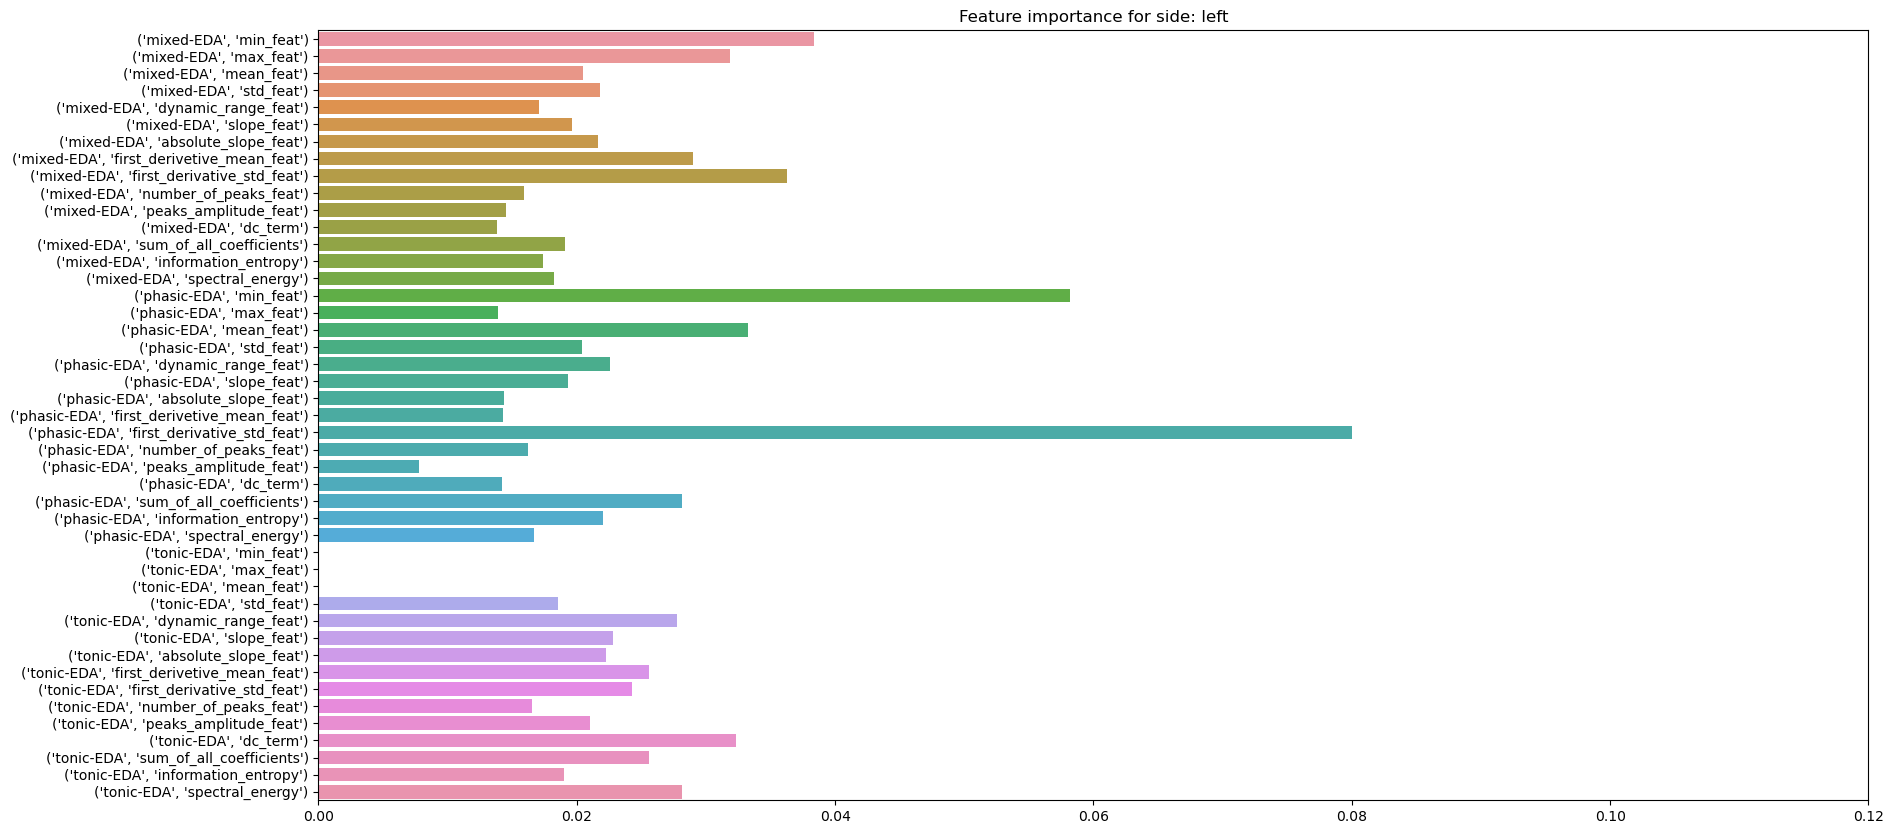

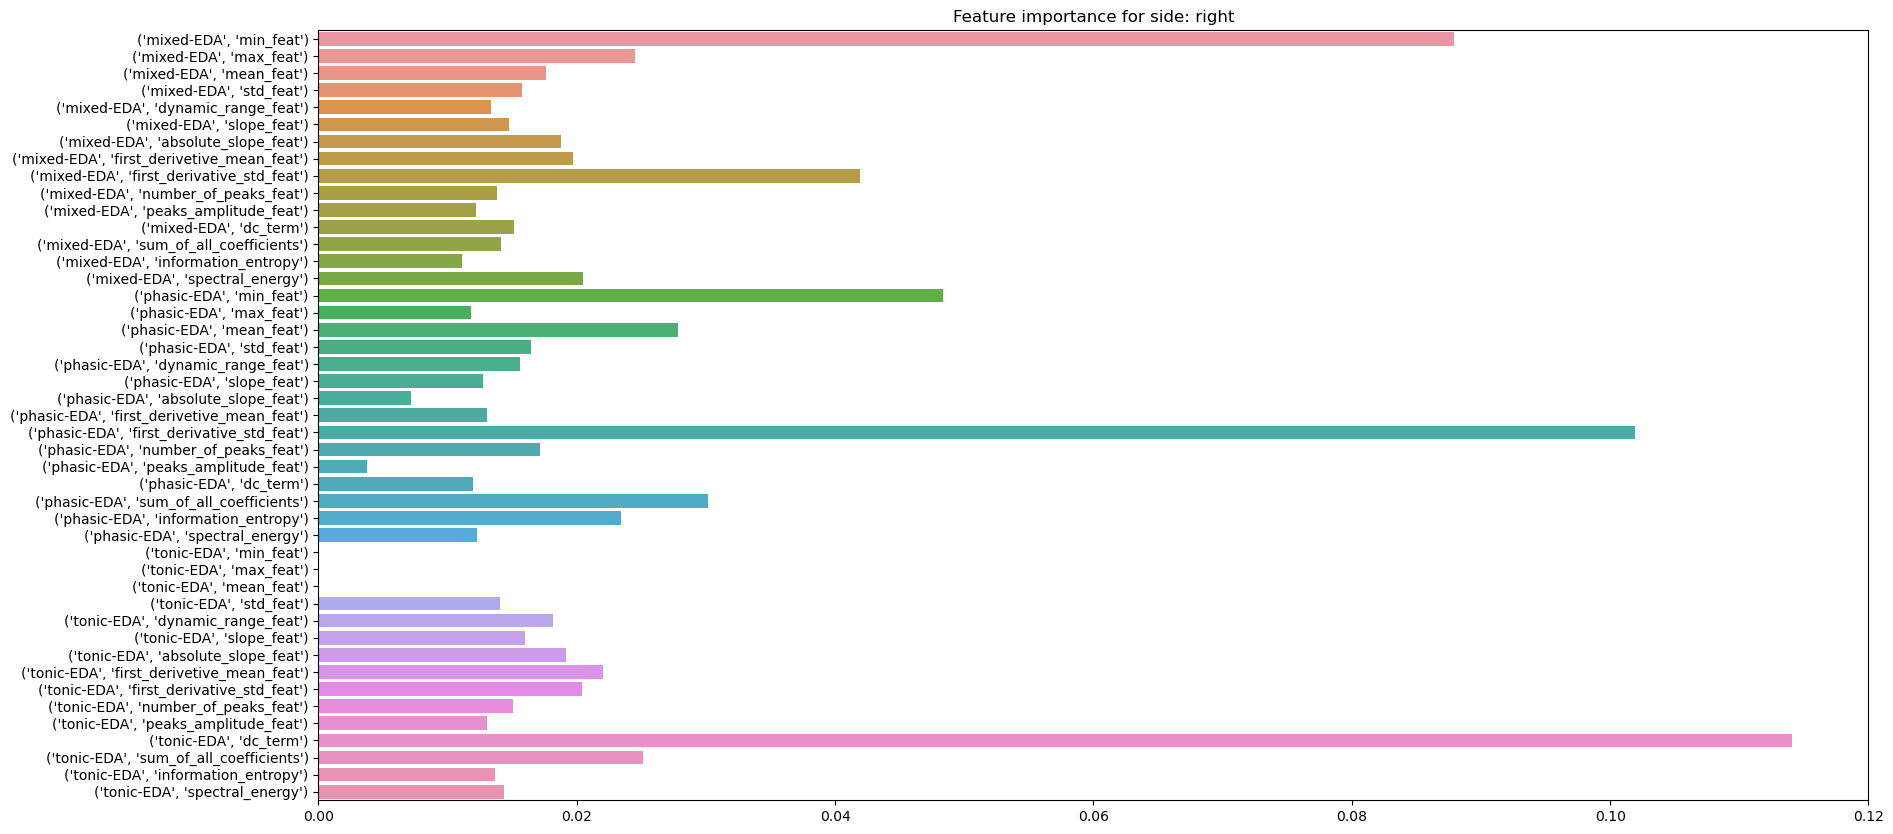

In [13]:
from matplotlib import pyplot as plt
import seaborn as sns

for side in ['left', 'right']:
    data_to_plot = df_avgs[df_avgs['side'] == side].iloc[0, 3:]
    plt.figure(figsize=(20, 10))
    plt.title('Feature importance for side: {}'.format(side))
    # make seaborn barplot
    sns.barplot(x=data_to_plot.values, y=data_to_plot.index)
    plt.xlim(0, 0.12)
    plt.show()

## MWC2022

In [9]:
path_to_save_data_avgs = "../data.nosync/mwc2022/results/nested_avg.h5"
# Create an empty dictionary to store the loaded DataFrames
df_avgs, upper_errs, lower_errs, df_errs = load_averaged_data(path_to_save_data_avgs)

Loading data:   0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
display(
    concat([df_errs["Balanced Accuracy"], df_avgs], axis=1, keys=["errors", "averages"])
    .groupby(("averages", "side"))
    .max()*100
)


errors  \
                 Balanced Accuracy   
(averages, side)                     
left                      0.306181   
lxrx                      0.676872   
right                     0.284035   
rxlx                      0.685272   

                                                           averages  \
                                                         classifier   
(averages, side)                                                      
left              XGBClassifierXGBClassifierXGBClassifierXGBClas...   
lxrx              XGBClassifierXGBClassifierXGBClassifierXGBClas...   
right             XGBClassifierXGBClassifierXGBClassifierXGBClas...   
rxlx              XGBClassifierXGBClassifierXGBClassifierXGBClas...   

                                    
                 Balanced Accuracy  
(averages, side)                    
left                     83.953194  
lxrx                     71.663898  
right                    80.479842  
rxlx                     75.558961

# Total data

In [1]:
from pandas import DataFrame, concat, MultiIndex, Series
from collections import defaultdict
from pandas import concat
from numpy import nanstd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import itertools
from pandas import HDFStore, DataFrame
from tqdm.auto import tqdm


def calculate_fold_df(data: DataFrame):
    avgs = concat(
        [fold_res["Balanced Accuracy"] for fold_res in data.values()],
        axis=1,
        keys=range(5),
    ).mean(axis=1)
    errs = concat(
        [fold_res["Balanced Accuracy"] for fold_res in data.values()],
        axis=1,
        keys=range(5),
    ).apply(lambda x: nanstd(x) / ((len(x - 1)) ** 0.5) if len(x) > 1 else 1, axis=1)
    return concat([avgs, errs], axis=1, keys=["Balanced Accuracy", "Standard Error"])


def concatenate_prepared_data(data: dict[str, DataFrame]) -> DataFrame:
    concated_df_dict: dict[DataFrame, Series] = {}
    sides: list[str] = ["left", "right", "lxrx", "rxlx"]
    for side in sides:
        concated_df_dict[side] = concat(
            [
                data[key][["Balanced Accuracy", "Standard Error"]].sort_index()
                for key in data.keys()
                if side in key
            ],
            axis=0,
            keys=[key[1:5] for key in data.keys() if side in key],
        )
        concated_df_dict[side].index = concated_df_dict[side].index.droplevel(0)

    all_results = concat(
        list(concated_df_dict.values()),
        axis=0,
        keys=sides,
        # ignore_index=True,
    )
    all_results = all_results.reset_index()
    all_results.columns = ["Side", "Model", "Balanced Accuracy", "Standard Error"]
    return all_results


def load_prepare_data(path_to_all_data: str) -> DataFrame:
    loaded_data = defaultdict(lambda: defaultdict(lambda: dict()))

    # Open the HDF5 file
    with HDFStore(path_to_save_data_avgs) as store:
        # Iterate through the keys (group names) in the HDF5 file
        for key in tqdm(store.keys(), desc="Loading data"):
            # Load each DataFrame and store it in the dictionary
            data = store[key]
            split_key = key.split("_")
            loaded_data[split_key[0]][split_key[1]][split_key[2]] = data

    loaded_data_correct = {
        f"{key1}_{key2}": calculate_fold_df(loaded_data[key1][key2])
        for key1 in loaded_data.keys()
        for key2 in loaded_data[key1].keys()
    }

    return concatenate_prepared_data(data=loaded_data_correct)


def remove_dummy(data: DataFrame) -> DataFrame:
    return data[data["Model"] != "DummyClassifier"]


def make_violin_accuracy(
    data: DataFrame,
    sides: list[str],
    path_to_save_fig: str,
    small_fontsize: int = 14,
    medium_fontsize: int = 18,
    large_fontsize: int = 20,
    xlim: tuple[float, float] | None = None,
):
    # set seaborn style
    sns.set_style("darkgrid")

    # # set latex font
    plt.rcParams["mathtext.fontset"] = "stix"
    plt.rcParams["font.family"] = "STIXGeneral"
    # plt.rcParams.update({"font.size": figsize *8})
    plt.rcParams["axes.grid"] = True

    # increase font size
    plt.rc("font", size=small_fontsize)  # controls default text sizes
    plt.rc("axes", titlesize=medium_fontsize)  # fontsize of the axes title
    plt.rc("axes", labelsize=large_fontsize)  # fontsize of the x and y labels
    plt.rc("xtick", labelsize=small_fontsize)  # fontsize of the tick labels
    plt.rc("ytick", labelsize=small_fontsize)  # fontsize of the tick labels
    plt.rc("legend", fontsize=medium_fontsize)  # legend fontsize
    plt.rc("figure", titlesize=large_fontsize)  # fontsize of the figure title
    plt.rcParams.update({"font.size": medium_fontsize})

    ax = sns.violinplot(
        data=data,
        y="Train-Test",
        x="Balanced Accuracy",
        palette="colorblind",
        orient="h",
    )
    annotator = Annotator(
        ax,
        list(itertools.combinations(sides, 2)),
        data=data,
        x="Balanced Accuracy",
        y="Train-Test",
        orient="h",
        order=sides,
    )
    annotator.configure(
        test="Mann-Whitney",
        comparisons_correction="BH",
        text_format="star",
        loc="outside",
    )
    annotator.apply_and_annotate()

    # set vertical line at 0.5
    plt.axvline(x=0.5, color="black", linestyle="--", linewidth=1)
    if xlim:
        plt.xlim(xlim)
    plt.savefig(path_to_save_fig, bbox_inches="tight")
    plt.show()


def clean_side_names(
    data: DataFrame, renaming_dict: dict[str, str] | None = None
) -> DataFrame:
    if renaming_dict is None:
        renaming_dict = {
            "left": "Left-Left",
            "right": "Right-Right",
            "lxrx": "Left-Right",
            "rxlx": "Right-Left",
        }
    renaming_dict: dict[str, str]
    data.loc[:, "Side"] = data.loc[:, "Side"].map(renaming_dict)
    return data.rename(columns={"Side": "Train-Test"}, inplace=False)


## USILaughs

In [4]:
path_to_save_data_avgs = "../data.nosync/usilaughs/results/nested_all.h5"

order = [
    "Left-Left",
    "Right-Right",
    "Left-Right",
    "Right-Left",
]
# Create an empty dictionary to store the loaded DataFrames
all_results = load_prepare_data(path_to_save_data_avgs)
all_results_no_dummy = remove_dummy(data=all_results)
all_results_no_dummy = clean_side_names(data=all_results_no_dummy)


Loading data:   0%|          | 0/1500 [00:00<?, ?it/s]

/tmp/ipykernel_572438/2960117792.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "Side"] = data.loc[:, "Side"].map(renaming_dict)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Left-Left vs. Right-Right: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:0.000e+00 U_stat=1.667e+06
Right-Right vs. Left-Right: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:0.000e+00 U_stat=7.994e+06
Left-Right vs. Right-Left: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.331e-299 U_stat=7.521e+06
Left-Left vs. Left-Right: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.017e-19 U_stat=4.247e+06
Right-Right vs. Right-Left: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:0.000e+00 U_stat=9.597e+06
Left-Left vs. Right-Left: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.614e-130 U_stat=6.612e+06


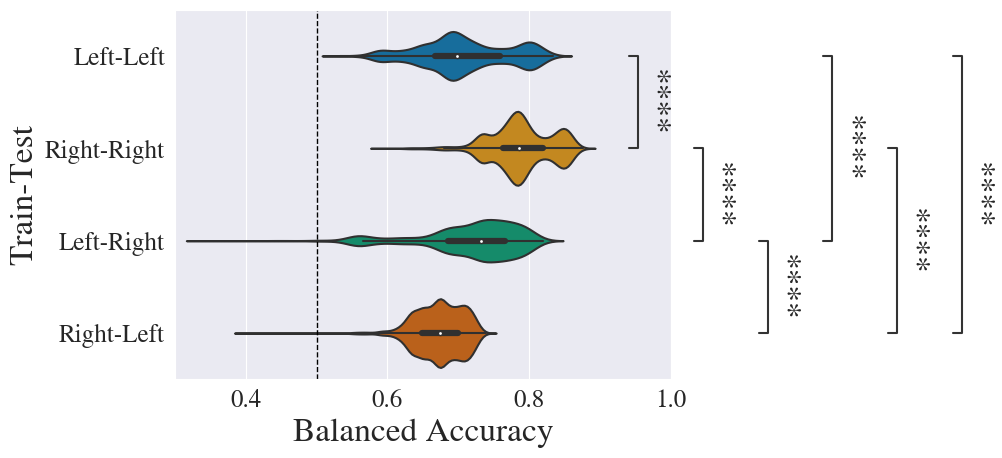

In [5]:
make_violin_accuracy(
    data=all_results_no_dummy,
    sides=order,
    path_to_save_fig="../final_visualizations/violin_nested_accuracy_usilaughs.pdf",
    xlim=(0.3,1),
    small_fontsize=18, 
    medium_fontsize=24,
    large_fontsize=25,
)


In [6]:
average_acc = all_results_no_dummy.groupby('Train-Test')['Balanced Accuracy'].mean()
# NOTE: this error estimation is not actually correct.
err_acc = all_results_no_dummy.groupby('Train-Test')['Balanced Accuracy'].std() / (all_results_no_dummy.groupby('Train-Test')['Balanced Accuracy'].count().apply(lambda x: x**0.5))
for i in range(len(average_acc)):
    # print accuracy with format '0.2f' (2 decimal places)
    print('Average accuracy for {} side: {:.2f} ± {:.2f}'.format(average_acc.index[i], average_acc[i]*100, err_acc[i]*100))

Average accuracy for Left-Left side: 70.84 ± 0.11
Average accuracy for Left-Right side: 71.61 ± 0.13
Average accuracy for Right-Left side: 67.22 ± 0.06
Average accuracy for Right-Right side: 78.81 ± 0.08


In [7]:
max_acc = all_results_no_dummy.groupby('Train-Test').max()
display(max_acc)

,Model,Balanced Accuracy,Standard Error
Train-Test,,,
Left-Left,XGBClassifier,0.834444,0.068958
Left-Right,XGBClassifier,0.819722,1.000000
Right-Left,XGBClassifier,0.739444,1.000000
Right-Right,XGBClassifier,0.875833,0.088371


## MWC2022

In [8]:
path_to_save_data_avgs = "../data.nosync/mwc2022/results/nested_all.h5"

order = [
    "Left-Left",
    "Right-Right",
    "Left-Right",
    "Right-Left",
]
# Create an empty dictionary to store the loaded DataFrames
all_results = load_prepare_data(path_to_save_data_avgs)
all_results_no_dummy = remove_dummy(data=all_results)
all_results_no_dummy = clean_side_names(data=all_results_no_dummy)


Loading data:   0%|          | 0/1500 [00:00<?, ?it/s]

/tmp/ipykernel_572438/2960117792.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "Side"] = data.loc[:, "Side"].map(renaming_dict)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Left-Left vs. Right-Right: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.458e-133 U_stat=6.637e+06
Right-Right vs. Left-Right: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.563e-134 U_stat=6.638e+06
Left-Right vs. Right-Left: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.963e-240 U_stat=2.524e+06
Left-Left vs. Left-Right: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:0.000e+00 U_stat=8.315e+06
Right-Right vs. Right-Left: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.309e-11 U_stat=4.400e+06
Left-Left vs. Right-Left: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.510e-152 U_stat=6.754e+06


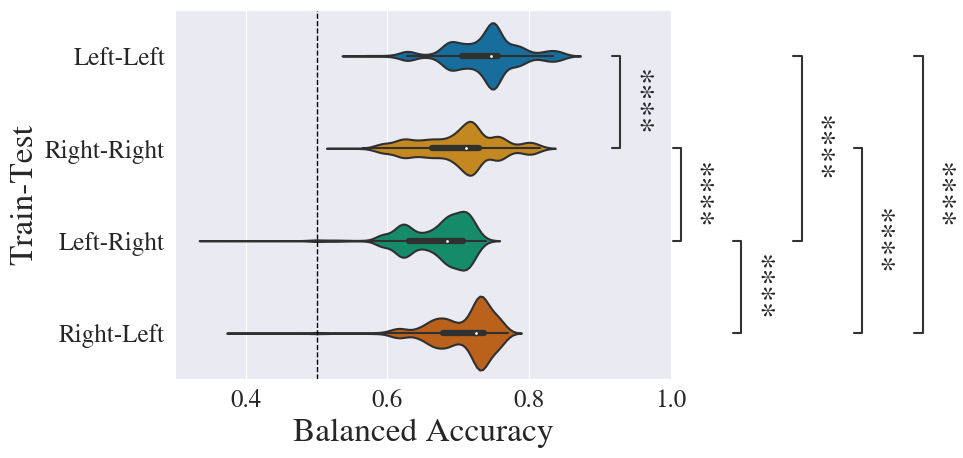

In [9]:
make_violin_accuracy(
    data=all_results_no_dummy,
    sides=order,
    path_to_save_fig="../final_visualizations/violin_nested_accuracy_mwc2022.pdf",
    xlim=(0.3,1),
    small_fontsize=18, 
    medium_fontsize=24,
    large_fontsize=25,
)


In [10]:
average_acc = all_results_no_dummy.groupby('Train-Test')['Balanced Accuracy'].mean()
# NOTE: this error estimation is not actually correct.
err_acc = all_results_no_dummy.groupby('Train-Test')['Balanced Accuracy'].std() / (all_results_no_dummy.groupby('Train-Test')['Balanced Accuracy'].count().apply(lambda x: x**0.5))
for i in range(len(average_acc)):
    # print accuracy with format '0.2f' (2 decimal places)
    print('Average accuracy for {} side: {:.2f} ± {:.2f}'.format(average_acc.index[i], average_acc[i]*100, err_acc[i]*100))

Average accuracy for Left-Left side: 73.70 ± 0.09
Average accuracy for Left-Right side: 67.00 ± 0.08
Average accuracy for Right-Left side: 70.52 ± 0.09
Average accuracy for Right-Right side: 70.18 ± 0.10


In [11]:
max_acc = all_results_no_dummy.groupby('Train-Test').max()
display(max_acc)

,Model,Balanced Accuracy,Standard Error
Train-Test,,,
Left-Left,XGBClassifier,0.852486,0.060536
Left-Right,XGBClassifier,0.739617,1.000000
Right-Left,XGBClassifier,0.770070,1.000000
Right-Right,XGBClassifier,0.815008,0.066661
